In [25]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the ticker symbol
tickerSymbol = 'AAPL'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get minute-level historical prices for the last few days
data = tickerData.history(period="50d", interval="5m")

# Resample the data to 6-minute intervals
data_resampled = data['Close']

# Display the data
print(data_resampled.head())


Datetime
2024-02-02 09:30:00-05:00    181.547607
2024-02-02 09:35:00-05:00    182.179993
2024-02-02 09:40:00-05:00    182.570007
2024-02-02 09:45:00-05:00    183.190002
2024-02-02 09:50:00-05:00    182.410004
Name: Close, dtype: float64


In [26]:
from sklearn.preprocessing import MinMaxScaler

def create_sequences(data, sequence_length=100):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length * 2 + 1):
        x = data[i:(i + sequence_length)]
        # Modify this line to make the first element of y equal to the last element of x
        y = data[(i + sequence_length - 1):(i + sequence_length * 2 - 1)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_resampled.values.reshape(-1, 1))

# Create sequences
sequence_length = 10
X, y = create_sequences(data_scaled, sequence_length)
X, y


(array([[[0.61937129],
         [0.64665149],
         [0.66347617],
         ...,
         [0.68030018],
         [0.70747704],
         [0.72274827]],
 
        [[0.64665149],
         [0.66347617],
         [0.69022187],
         ...,
         [0.70747704],
         [0.72274827],
         [0.71481052]],
 
        [[0.66347617],
         [0.69022187],
         [0.65657383],
         ...,
         [0.72274827],
         [0.71481052],
         [0.6956142 ]],
 
        ...,
 
        [[0.23769794],
         [0.24848259],
         [0.24438437],
         ...,
         [0.262723  ],
         [0.26207134],
         [0.26405989]],
 
        [[0.24848259],
         [0.24438437],
         [0.25624787],
         ...,
         [0.26207134],
         [0.26405989],
         [0.25452196]],
 
        [[0.24438437],
         [0.25624787],
         [0.27393419],
         ...,
         [0.26405989],
         [0.25452196],
         [0.25754198]]]),
 array([[[0.72274827],
         [0.71481052],
         

In [27]:
# Assuming you have already created 'X' and 'y' from previous steps

# Determine the split point
train_size = int(len(X) * 0.75)
test_size = len(X) - train_size

# Split the data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Prepare decoder input data for training and testing
decoder_input_train = np.zeros((X_train.shape[0], sequence_length, 1))
decoder_input_test = np.zeros((X_test.shape[0], sequence_length, 1))


In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Model architecture
encoder_inputs = Input(shape=(sequence_length, 1))
encoder = LSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(sequence_length, 1))
decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 10, 1)]      0           []                               
                                                                                                  
 lstm_14 (LSTM)                 [(None, 50),         10400       ['input_9[0][0]']                
                                 (None, 50),                                                      
                                 (None, 50)]                                                      
                                                                                            

In [29]:
# Prepare decoder input data that just contains zeros
decoder_input_data = np.zeros((X.shape[0], sequence_length, 1))


# Fit the model
model.fit([X_train, decoder_input_train], y_train, batch_size=32, epochs=10, validation_split=0.2)


Epoch 1/10
73/73 [==============================] - 4s 16ms/step - loss: 0.0430 - val_loss: 0.0021
Epoch 2/10
73/73 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/10
73/73 [==============================] - 1s 9ms/step - loss: 9.8826e-04 - val_loss: 0.0010
Epoch 4/10
73/73 [==============================] - 1s 10ms/step - loss: 9.2081e-04 - val_loss: 0.0010
Epoch 5/10
73/73 [==============================] - 0s 6ms/step - loss: 9.0916e-04 - val_loss: 0.0010
Epoch 6/10
73/73 [==============================] - 1s 8ms/step - loss: 8.9469e-04 - val_loss: 0.0010
Epoch 7/10
73/73 [==============================] - 1s 9ms/step - loss: 8.9657e-04 - val_loss: 0.0010
Epoch 8/10
73/73 [==============================] - 1s 9ms/step - loss: 8.9235e-04 - val_loss: 9.8617e-04
Epoch 9/10
73/73 [==============================] - 1s 10ms/step - loss: 8.8363e-04 - val_loss: 9.7209e-04
Epoch 10/10
73/73 [==============================] - 1s 7ms/step - loss: 8.6630

31/31 [==============================] - 1s 4ms/step


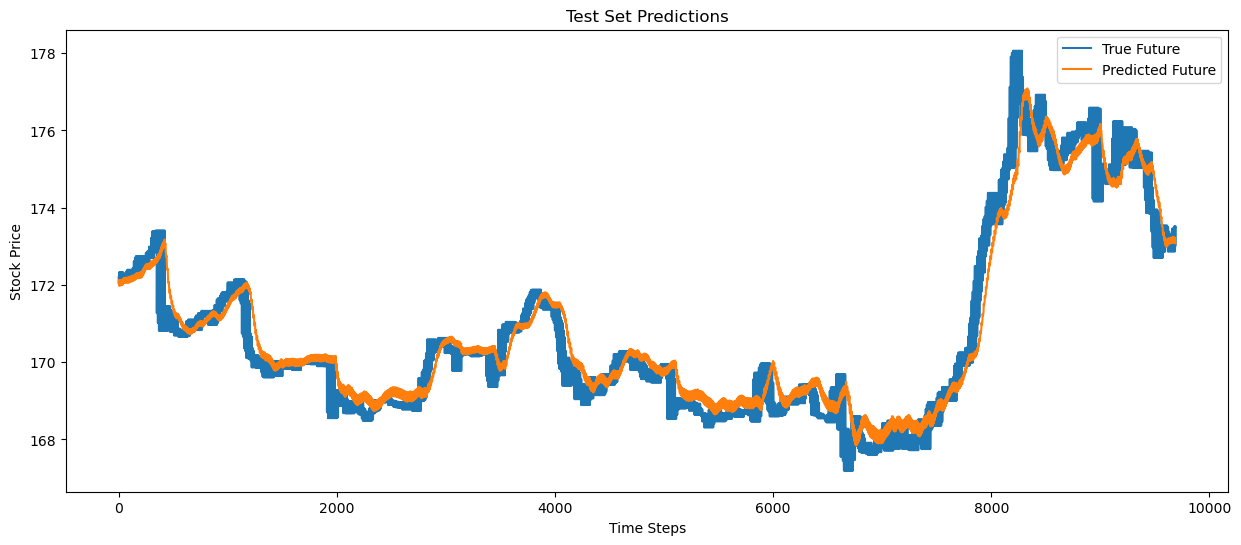

In [30]:
predicted_output_test = model.predict([X_test, decoder_input_test])
predicted_output_test = scaler.inverse_transform(predicted_output_test.reshape(-1, 1))
actual_output_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualizing the results
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
plt.plot(actual_output_test, label='True Future')
plt.plot(predicted_output_test, label='Predicted Future')
plt.title('Test Set Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [38]:
import numpy as np

# Assume last_sequence is initially the last known sequence
last_sequence = X[-1].reshape((1, sequence_length, 1))

# Prepare a zero array for the decoder input
decoder_input_predict = np.zeros((1, sequence_length, 1))

# Store all predictions
all_predictions = []

# Generate predictions step by step
for _ in range(10):  # number of sequences to predict
    # Predict the next sequence
    new_predicted_sequence = model.predict([last_sequence, decoder_input_predict])
    
    # Properly reshape the predicted output to match the input sequence dimensions
    new_predicted_sequence_reshaped = new_predicted_sequence.reshape(1, sequence_length, 1)
    
    # Update the last sequence: shift left and insert new predictions at the end
    last_sequence[:, :sequence_length-1, :] = last_sequence[:, 1:, :]
    last_sequence[:, -1:, :] = new_predicted_sequence_reshaped[:, -1:, :]
    
    # Store the prediction
    all_predictions.extend(new_predicted_sequence_reshaped.flatten())

# Convert all_predictions to a numpy array for easier handling
all_predictions = np.array(all_predictions)

# Inverse scale the predicted values to get actual price predictions
predicted_prices = scaler.inverse_transform(all_predictions.reshape(-1, 1))

# Display the predicted prices for the next 10 sequences
print(predicted_prices)


1/1 [==============================] - 0s 28ms/step
[[171.58992]
 [171.52611]
 [171.48798]
 [171.46873]
 [171.46332]
 [171.46796]
 [171.47989]
 [171.49706]
 [171.51797]
 [171.5415 ]
 [171.58992]
 [171.52611]
 [171.48798]
 [171.46873]
 [171.46332]
 [171.46796]
 [171.47989]
 [171.49706]
 [171.51797]
 [171.5415 ]
 [171.58992]
 [171.52611]
 [171.48798]
 [171.46873]
 [171.46332]
 [171.46796]
 [171.47989]
 [171.49706]
 [171.51797]
 [171.5415 ]
 [171.58992]
 [171.52611]
 [171.48798]
 [171.46873]
 [171.46332]
 [171.46796]
 [171.47989]
 [171.49706]
 [171.51797]
 [171.5415 ]
 [171.58992]
 [171.52611]
 [171.48798]
 [171.46873]
 [171.46332]
 [171.46796]
 [171.47989]
 [171.49706]
 [171.51797]
 [171.5415 ]
 [171.58992]
 [171.52611]
 [171.48798]
 [171.46873]
 [171.46332]
 [171.46796]
 [171.47989]
 [171.49706]
 [171.51797]
 [171.5415 ]
 [171.58992]
 [171.52611]
 [171.48798]
 [171.46873]
 [171.46332]
 [171.46796]
 [171.47989]
 [171.49706]
 [171.51797]
 [171.5415 ]
 [171.58992]
 [171.52611]
 [171.48798]

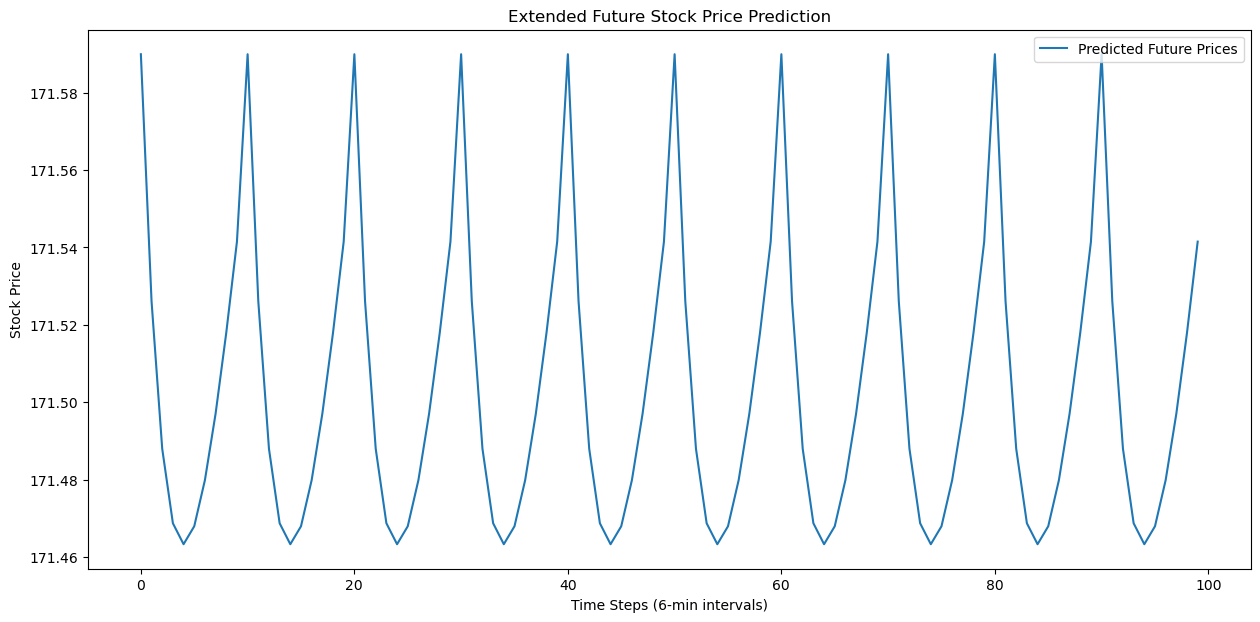

In [39]:
# Prepare the plot
plt.figure(figsize=(15, 7))

# Plot predicted data
plt.plot(predicted_prices, label='Predicted Future Prices')

plt.title('Extended Future Stock Price Prediction')
plt.xlabel('Time Steps (6-min intervals)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
